In [2]:
import pandas as pd
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise import NormalPredictor, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline, SVD, BaselineOnly, SVDpp, NMF
from surprise import SlopeOne, CoClustering, accuracy
from surprise.accuracy import rmse
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
user = pd.read_csv('../BX-CSV-Dump/BX-Users.csv', sep=';', encoding='latin-1', error_bad_lines=False)
user.columns = ['userID', 'Location', 'Age']
rating = pd.read_csv('../BX-CSV-Dump/BX-Book-Ratings.csv', sep=';', encoding='latin-1', error_bad_lines=False)
rating.columns = ['userID', 'ISBN', 'bookRating']

In [4]:
user.head()
print(user.shape)

(278858, 3)


In [5]:
rating.head()
print(rating.shape)

(1149780, 3)


In [6]:
df = pd.merge(user, rating, how='inner', on='userID')
df.drop(['Location', 'Age'], inplace=True, axis=1)
df.head()

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [7]:
df.shape

(1149780, 3)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
userID        1149780 non-null int64
ISBN          1149780 non-null object
bookRating    1149780 non-null int64
dtypes: int64(2), object(1)
memory usage: 35.1+ MB


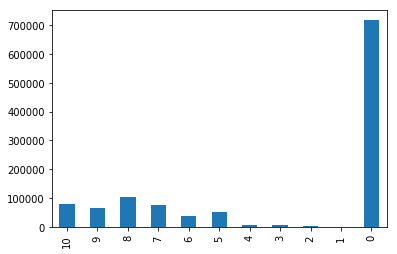

In [9]:
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

df['bookRating'].value_counts().sort_index(ascending=False).plot.bar()

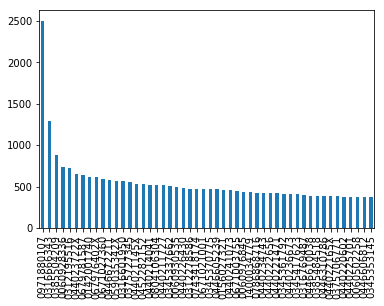

In [11]:
df['ISBN'].value_counts()[:50].plot.bar()

In [14]:
data = df.groupby('userID')['bookRating'].count().clip(upper=50)

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 50,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 50)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


In [15]:
df.groupby('userID')['bookRating'].count().reset_index().sort_values('bookRating', ascending=False)[:10]

,userID,bookRating
4213,11676,13602
74815,198711,7550
58113,153662,6109
37356,98391,5891
13576,35859,5850
80185,212898,4785
105111,278418,4533
28884,76352,3367
42037,110973,3100
88584,235105,3067


In [27]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) & (df['userID'].isin(filter_users))]
print(df.shape, df_new.shape)

(1149780, 3) (140516, 3)


In [28]:
reader = Reader(rating_scale=(0,9))
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

In [30]:
benchmark = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), 
                  KNNWithZScore(), BaselineOnly(), CoClustering()]:
    
    results = cross_validate(algorithm, data, measures=['rmse'], cv=3, verbose=False)
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [31]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,fit_time,test_rmse,test_time
Algorithm,,,
BaselineOnly,0.331432,3.378239,0.661202
CoClustering,4.816464,3.466744,0.762878
SlopeOne,1.191430,3.470971,7.615777
KNNWithMeans,1.330711,3.488824,10.296766
KNNBaseline,1.500621,3.489301,12.768760
KNNWithZScore,1.704273,3.505503,11.760804
SVD,12.022912,3.550800,1.067676
KNNBasic,1.175036,3.727864,9.389125
SVDpp,273.154697,3.784227,12.873286


In [32]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'fit_time': (0.182342529296875, 0.2049567699432373, 0.21874332427978516),
 'test_rmse': array([3.37213303, 3.37845716, 3.3742408 ]),
 'test_time': (0.5759932994842529, 0.7560873031616211, 0.7255678176879883)}

https://towardsdatascience.com/building-and-testing-recommender-systems-with-surprise-step-by-step-d4ba702ef80b